Обучение нейронной сети для распознавания рукописных цифр на основе датасета MNIST

In [ ]:
from torch import nn
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import dataset
import numpy as np
import pandas as pd

Обучаем на gpu, для большей скорости

In [ ]:
# Проверка доступности CUDA
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA доступен, устройство:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("CUDA недоступен, используется CPU")

CUDA доступен, устройство: Tesla T4


In [ ]:
from torchvision import datasets

mnist = datasets.MNIST(root='mnist', download=True)

mnist

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.92MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.68MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train

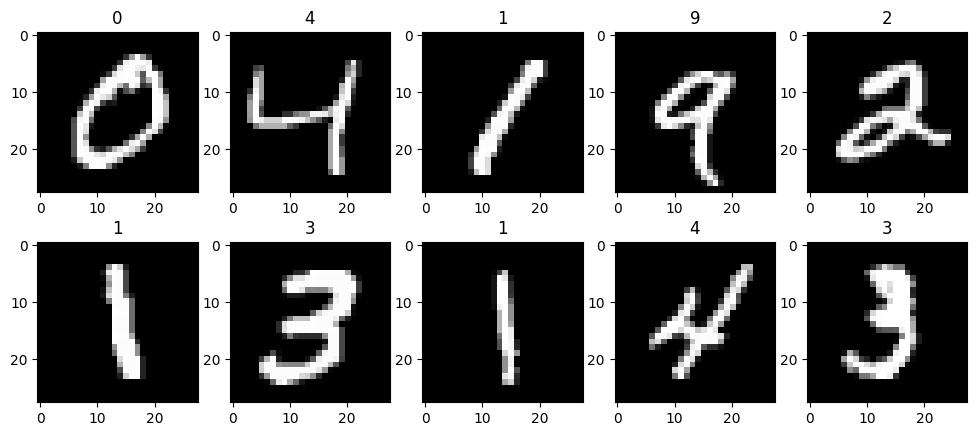

In [ ]:
#выводим объекты датасета

plt.figure(figsize=(12, 5))

for i in range(1, 11):
  plt.subplot(2, 5, i)
  plt.imshow(mnist[i][0], cmap="gray")
  plt.title(mnist[i][1])

plt.show()

In [ ]:
mnist[0][0].size # от размера изображения зависит количество параметров

(28, 28)

Создадим пять нейронных сетей. Однуслойную, двуслойную, с dropout и с batchnorm, и со всеми технологиями разом

In [ ]:
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.LogSoftmax(dim=1)
)

model_dropout = nn.Sequential( # с дропом части нейронов входного слоя
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.LogSoftmax(dim=1)
)

model_batchnorm = nn.Sequential( # с нормализацией выходов слоев
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.LogSoftmax(dim=1)
)

model_big = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(20, 10),
    nn.LogSoftmax(dim=1)
)


models = [model1, model2, model_dropout, model_batchnorm, model_big]

for model in range(len(models)):
  models[model] = models[model].to(device) # переводит модели на gpu/cpu

In [ ]:
from torchsummary import summary

for model in models:
  summary(model, (28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
        LogSoftmax-5                   [-1, 10]               0
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1

In [ ]:
for i, model in enumerate(models):
  param_count = 0
  for p in model.parameters():
    param_count += torch.numel(p)

  print(f"Количество параметров в {i + 1} нейросети: {param_count}")

Количество параметров в 1 нейросети: 101770
Количество параметров в 2 нейросети: 103270
Количество параметров в 3 нейросети: 103270
Количество параметров в 4 нейросети: 103566
Количество параметров в 5 нейросети: 103566


Разница в параметрах возникает из-за

Напишем функцию отображающую обучение нейросети, с помощью графика лосса

In [ ]:
from IPython.display import clear_output

def show_learning(train_loss, test_loss):
  models = len(train_loss)

  clear_output()
  plt.figure(figsize=(12, 5 * models))

  for i in range(models):
    plt.subplot(models, 2, 2 * i + 1)
    plt.plot(train_loss[i])
    plt.title("Train")

    plt.subplot(models, 2, 2 * (i + 1))
    plt.plot(test_loss[i])
    plt.title("Test")

  plt.show()

А также функцию обучения и запуска

In [ ]:
def train_model(model, data_loader, loss, optimizer):
  model.train()

  sum_loss = 0
  for x, y in data_loader:
    x = x.to(device)
    y = y.to(device)

    pred_y = model(x)
    res_loss = loss(pred_y, y)
    sum_loss += res_loss

    res_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return float(sum_loss / len(data_loader))

def forward_model(model, dataloader, loss):
  model.eval()
  sum_loss = 0

  with torch.no_grad():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)

      pred = model(x)
      res_loss = loss(pred, y)
      sum_loss += res_loss.item()

    return float(sum_loss / len(dataloader))

Обработаем датасет, чтобы можно было представить картинки в виде тензоров. А также разделим на тренировучную/тестовую 0.8/0.2


In [ ]:
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

transformer = ToTensor()

mnist_data = np.array([transformer(mnist[i][0]).numpy() for i in range(len(mnist))])
mnist_target = np.array([mnist[i][1] for i in range(len(mnist))])

x_train, x_test, y_train, y_test = train_test_split(mnist_data, mnist_target, test_size=0.2, random_state=42)

x_train = torch.from_numpy(x_train).to(dtype=torch.float32)
x_test = torch.from_numpy(x_test).to(dtype=torch.float32)
y_train = torch.from_numpy(y_train).to(dtype=torch.int64)
y_test = torch.from_numpy(y_test).to(dtype=torch.int64)

mnist_train = TensorDataset(x_train, y_train)
mnist_test = TensorDataset(x_test, y_test)

Данные будет подавать батчами через лоадер, и использовать negative likelihood loss, тк задача классификации с несколькими классами. Она работает аналогично с Cross entropy, но тк в функции торча CrossEntropyLoss встроен, софтмакс, который есть и на выходах моделей, работать с этой функции нельзя. Иначе нужно убрать софтмакс из моделей, и применять его вручную

In [ ]:
from torch.utils.data import DataLoader
from torch import optim

batch_size = 200

dataload_train = DataLoader(mnist_train, batch_size=batch_size) # создаем лоадер, подающий данные по батчам
dataload_test = DataLoader(mnist_test, batch_size=batch_size)

loss = nn.NLLLoss()

Обучаем модели. Графики выводятся по порядку расположения моделей в models

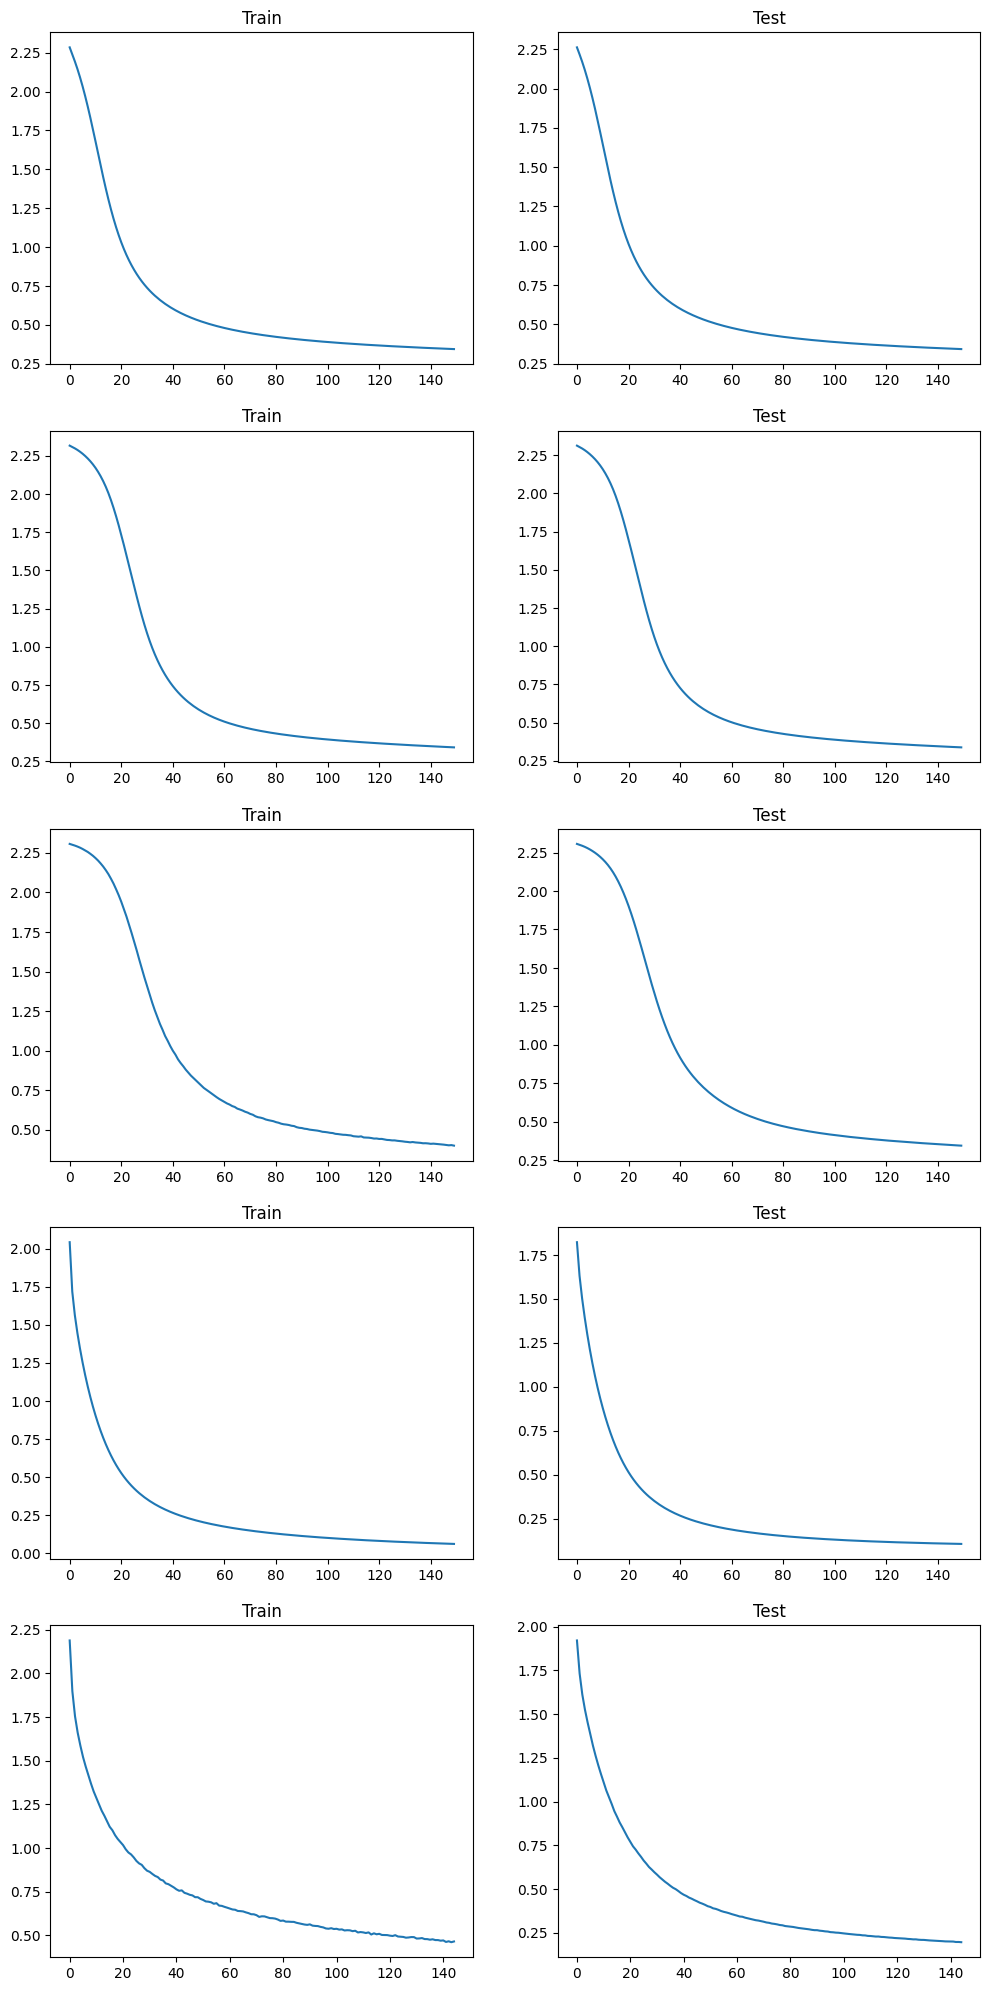

In [ ]:
epochs = 150

train_loss = []
test_loss = []
for mdl in range(len(models)):
  train_loss.append([])
  test_loss.append([])
  for i in range(epochs):
    optimizer = optim.SGD(models[mdl].parameters(), lr=0.001)
    train_loss[mdl].append(train_model(models[mdl], dataload_train, loss, optimizer))
    test_loss[mdl].append(forward_model(models[mdl], dataload_test, loss))

    if i % 9 == 0:
      show_learning(train_loss, test_loss)

Лоссы моделей сходятся и модели хорошо обучаются. Переобучения нет, тк тестовый лосс непротиворечит лоссу на обучении. Обучать на большем кол-ве эпох не имеет особого смысла, тк по лоссу видно, что его снижение на последних эпохах довольно незначительно. Хотя это может прибавить десятую метрик

Тестируем по метрикам модели

In [ ]:
mnist_test_data = datasets.MNIST(root='mnist', download=True, train=False)

mnist_data = np.array([transformer(mnist_test_data[i][0]).numpy() for i in range(len(mnist_test_data))])
mnist_target = np.array([mnist_test_data[i][1] for i in range(len(mnist_test_data))])
data = torch.from_numpy(mnist_data).to(dtype=torch.float32)
target = torch.from_numpy(mnist_target).to(dtype=torch.int64)

test_data = TensorDataset(data, target)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test(model, testdata, val_loss):
  model = model.to(torch.device('cpu'))
  x_test = testdata[:][0]
  y_test = testdata[:][1]

  y_proba = model(x_test)
  y_pred = torch.argmax(y_proba, dim=1)

  results = (
      min(val_loss),
      accuracy_score(y_test, y_pred),
      precision_score(y_test, y_pred, average="macro"),
      recall_score(y_test, y_pred, average="macro"),
      f1_score(y_test, y_pred, average="macro")
  )

  return results

In [ ]:
metric_table = pd.DataFrame(
    columns=["best_validation_loss", "accuracy", "precision", "recall", "f1"],
    index=["model1", "model2", "model_dropout", "model_batchnorm", "big_model"]
    )

for model in range(len(models)):
  results = test(models[model], test_data, test_loss[model])
  metric_table.iloc[model] = results

metric_table

,best_validation_loss,accuracy,precision,recall,f1
model1,0.342188,0.9073,0.90617,0.905918,0.905795
model2,0.338184,0.9028,0.901458,0.901339,0.901155
model_dropout,0.345667,0.9044,0.902917,0.902848,0.902606
model_batchnorm,0.106624,0.9731,0.972864,0.972813,0.972831
big_model,0.192937,0.9533,0.953057,0.952826,0.952841


Вывод: наибольшие показатели по всем метрикам имеет модель с нормализацией батчей между слоями, она показала наибольший прирост к эффективности. Однослойная модель на удивления справлялась лучше чем двуслойная, видимо из-за слишком простой задачи не требовалось увеличения слоев. Хуже всех себя показала двуслойная нейронка, но нейросеть с дропами нейронов, не сильно лучше, видимо из-за дропов некоторые нейроны недообучались. Аналогичная ситуация с большой моделью, она отстает от модели с нормализацией, из-за влияние dropout